# Project

## Train & Validation, Test Splitting

This section has been run previously. The output dataset can be found in the input folder

```python
src_dir = "../input/plantvillage/images" #r"../plant-pathology-2020-fgvc7/images"
train_val_dst_dir = "../working/train&val_images" #r"../plant-pathology-2020-fgvc7/train&val_images" #"../working/train&val_images"
test_dst_dir = "../working/test_images" #r"../plant-pathology-2020-fgvc7/test_images"  #"../working/test_images"
if not os.path.isdir(train_val_dst_dir):
    os.mkdir(train_val_dst_dir)
if not os.path.isdir(test_dst_dir):
    os.mkdir(test_dst_dir)


if len([f for f in os.listdir(test_dst_dir)]) == 0:


    all_images_names = os.listdir(src_dir)
    train_val_images = []
    test_images  = []
    for image in all_images_names:
        if "Train" in image:
            shutil.copy(src_dir+"/"+image,train_val_dst_dir)
        elif "Test" in image:
            shutil.copy(src_dir+"/"+image,test_dst_dir)
        else:
            print("error")

# check for possible errors
total = len([f for f in  os.listdir(src_dir)])
train_val_total = len([f for f in  os.listdir(train_val_dst_dir)])
test_total = len([f for f in  os.listdir(test_dst_dir)])
print(total == train_val_total + test_total)
```
[] : True

### Install latest version f tensorflow, which comes with useful image loading APIs

In [1]:
# run only once per session
!pip install tf-nightly

     |████████████████████████████████| 350.3 MB 33 kB/s s eta 0:00:01    |██████▏                         | 68.1 MB 54.9 MB/s eta 0:00:06     |███████████▊                    | 128.8 MB 46.9 MB/s eta 0:00:05     |████████████▊                   | 139.0 MB 46.9 MB/s eta 0:00:05     |█████████████                   | 141.5 MB 21.6 MB/s eta 0:00:10     |████████████████████████▉       | 272.1 MB 55.0 MB/s eta 0:00:02
     |████████████████████████████████| 459 kB 49.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 45.9 MB/s eta 0:00:01


### Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE # to balance classes


# plot model histories
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, confusion_matrix
import math

Using TensorFlow backend.


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Exploration

Here we get an insight of the datasets

In [4]:
kaggle = True
if kaggle:
    outdir = r"../working/"
    indir = r"../input/plantvillage/"
else:
    outdir = r"Q:/tooBigToDrive/plantsvillage/temp/"
    indir = r"Q:/tooBigToDrive/plantsvillage/"
    
test_dir = indir + "plantvillage_split_dataset/test_images"
train_labels_csv = pd.read_csv(indir+"plantvillage_split_dataset/train.csv")
print(train_labels_csv.head())
print("-------------------------------------")
example_submission_csv = pd.read_csv(indir+"plantvillage_split_dataset/sample_submission.csv")
print(example_submission_csv.head() )
print("-------------------------------------")
test_csv = pd.read_csv(indir+"plantvillage_split_dataset/test.csv")
test_paths_csv= pd.DataFrame(test_csv["image_id"].apply(lambda x: test_dir+"/"+x+".jpg"))
print(test_paths_csv.head() )

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
-------------------------------------
  image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25
-------------------------------------
                                            image_id
0  ../input/plantvillage/plantvillage_split_datas...
1  ../input/plantvillage/plantvillage_split_datas...
2  ../input/plantvillage/plantvillage_split_datas...
3  ../input/plantvillage/plantvillage_split_datas...
4  ../input/plantvillage/plantvillage_split_dat

## Train, Validation Splitting
This cell creates 4 directories (healthy, multiple_diseases, rust,scab) with the corresponding images from the train set

In [5]:
# create csvs with images
train_val_healthy_csv = train_labels_csv[train_labels_csv["healthy"] == 1]
train_val_multiple_diseases_csv  = train_labels_csv[train_labels_csv["multiple_diseases"] == 1]
train_val_rust_csv = train_labels_csv[train_labels_csv["rust"] == 1]
train_val_scab_csv = train_labels_csv[train_labels_csv["scab"] == 1]
# we will check that this has no entry
two_classes = train_labels_csv[(train_labels_csv["scab"] == 1) & (train_labels_csv["multiple_diseases"] == 1)]

train_val_healthy_names = train_val_healthy_csv["image_id"].tolist()
train_val_multiple_diseases_names = train_val_multiple_diseases_csv["image_id"].tolist()
train_val_rust_names = train_val_rust_csv["image_id"].tolist()
train_val_scab_names = train_val_scab_csv["image_id"].tolist()

src_dir = indir+"plantvillage_split_dataset/train&val_images" #"../input/plantvillage/images"
train_dst_dir = outdir+"train" #"../working/train&val_images"

#val_dst_dir = outdir+"val"  #"../working/test_images"
train_dst_healthy_dir = outdir+"train/healthy"#"../working/train&val_images"
train_dst_multiple_diseases_dir =outdir+"train/multiple_diseases"
train_dst_rust_dir = outdir+"train/rust"
train_dst_scab_dir = outdir+"train/scab"

test_dst_dir = outdir + "test_image/test"

# crreate teh directories and fill them
try:
    os.mkdir(train_dst_dir)

    os.mkdir(train_dst_healthy_dir)
    os.mkdir(train_dst_multiple_diseases_dir)
    os.mkdir(train_dst_rust_dir)
    os.mkdir(train_dst_scab_dir)
    os.makedirs(test_dst_dir)

    for image in train_val_healthy_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_healthy_dir)
            
    for image in train_val_multiple_diseases_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_multiple_diseases_dir)

    for image in train_val_rust_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_rust_dir)

    for image in train_val_scab_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_scab_dir)

    for image in test_paths_csv["image_id"].tolist():
        shutil.copy(image,test_dst_dir)
        
except FileExistsError as err:
    print("folders already exist")
 
#check for possible errors
total = len([f for f in  os.listdir(src_dir)])
train_healthy_total = len([f for f in  os.listdir(train_dst_healthy_dir)])
train_multiple_diseases_total = len([f for f in  os.listdir(train_dst_multiple_diseases_dir)])
train_rust_total = len([f for f in  os.listdir(train_dst_rust_dir)])
train_scab_total = len([f for f in  os.listdir(train_dst_scab_dir)])

total = train_healthy_total + train_multiple_diseases_total +train_rust_total+ train_scab_total #steps_per_epoch = 
train_size = math.ceil(total*0.8)
val_size = total - train_size
test_size = test_csv.size 
image_size  = (200,200)
batch_size = 32
print(train_healthy_total,train_multiple_diseases_total,train_rust_total,train_scab_total,)

516 91 622 592


## Class balancing and Data Augmentation/Prepocessing
This function performs class balancing and data augmentation. Classes are balanced with SMOTE, while data augmentation is performed with tendorflow's ImageDataGenerator. <br>
Multiple variants of SMOTE and ImageDataGenerator have been tried, resulting in the following optimal configuration which also cares about performance. <br>
Note that the function is split in two by the `valid` parameter: it allows to use the function to produce both the train and validation data and the train only. <br>

In [6]:
def create_augmented_data(train_dst_dir , train_generator, val_generator, aug, batch_size, valid = True):
    if valid:
        # load data into tensorflow dataset: if we used the flow_form_directory method of the train_generator, it would go too slow
        print("loading data...")
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dst_dir,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=train_size, #batch_size
        )

        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_dst_dir,
            #val_dst_dir,
            validation_split=0.2,
            subset="validation",
            seed=1337,
            image_size=image_size,
            batch_size=val_size,
        )
        
        print("augmenting train...")
        res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
        x_train = np.array(res[0])
        print("x done")
        y_train = np.array(res[1])
        yforpca = y_train
        print(x_train.shape,y_train.shape)
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution before smote = ", counts)
        x_train  = np.array([image.flatten() for image in x_train ])
        xforpca = x_train
        print("flattened")

        smote_train = SMOTE(sampling_strategy = "minority", random_state = 420,k_neighbors=10,n_jobs=4)   #svmsmote goues aout of memory in all configs
        x_train, y_train = smote_train.fit_resample(x_train, y_train)
        x_train = np.reshape(x_train,(-1,200,200,3))
        tot_train = len(x_train)
        print("total_train after smote = ", x_train.shape)
        yforpca1 = y_train #
        xforpca1 = x_train  #
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution after smote = ", counts)
        y_train_cat = tf.keras.utils.to_categorical(
            y_train, num_classes=4, dtype='float32'
        )
        
        
        train_generator.fit(x_train)
        aug_train_images, aug_train_labels = train_generator.flow(x = x_train,y = y_train_cat,shuffle = False,batch_size = tot_train).next() #batch_size = train_size #seed = 102
        aug_train_images = np.array(aug_train_images)
        aug_train_labels = np.array(aug_train_labels)
        
        # save memory
        del x_train
        #del y_train
        del train_ds

        out_train_datagen = ImageDataGenerator()
        out_train_datagen.fit(aug_train_images)
        out_train_flow = out_train_datagen.flow(aug_train_images,aug_train_labels,batch_size = batch_size,shuffle = False)

        del aug_train_images
        del aug_train_labels

        print("train augmented, augmenting val...")
        #i = 0
        res = list(zip(*val_ds.unbatch().as_numpy_iterator()))
        x_val = np.array(res[0])
        y_val = np.array(res[1])
        y_val_cat = tf.keras.utils.to_categorical(
            y_val, num_classes=4, dtype='float32'
        )
        print(x_val.shape,y_val.shape,y_val_cat.shape)
        
        
        val_generator.fit(x_val)
        aug_val_images, aug_val_labels = val_generator.flow(x = x_val,y = y_val_cat,shuffle = False,batch_size = val_size).next()
        aug_val_images = np.array(aug_val_images)
        aug_val_labels = np.array(aug_val_labels)

        del x_val
        del val_ds

        out_val_datagen = ImageDataGenerator()
        out_val_datagen.fit(aug_val_images)
        out_val_flow = out_val_datagen.flow(aug_val_images,aug_val_labels,batch_size = val_size, shuffle = False)

        del aug_val_images
        del aug_val_labels
        del res

        print("returning")
        return (out_train_flow,out_val_flow,y_val,y_train,tot_train)
    # if validation is not provided/ one intends to test
    else:
        print("loading data...")
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dst_dir,
        #validation_split=0.2,
        #subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=train_size, #batch_size
        )
        
        print("augmenting train...")
        res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
        x_train = np.array(res[0])
        y_train = np.array(res[1])
        print(x_train.shape,y_train.shape)
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution before smote = ", counts)
        x_train  = np.array([image.flatten() for image in x_train ])
        print("flattened")
        yforpca = y_train 
        xforpca = x_train  
        smote_train = SMOTE(sampling_strategy = "minority", random_state = 420,k_neighbors=10,n_jobs=4)
        x_train, y_train = smote_train.fit_resample(x_train, y_train)
        x_train = np.reshape(x_train,(-1,200,200,3))
        yforpca1 = y_train #
        xforpca1 = x_train #
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution after smote = ", counts)
        tot_train = len(x_train)
        print("total_train after smote = ", x_train.shape)
        
        y_train_cat = tf.keras.utils.to_categorical(
            y_train, num_classes=4, dtype='float32'
        )   

        train_generator.fit(x_train)
        aug_train_images, aug_train_labels = train_generator.flow(x = x_train,y = y_train_cat,shuffle = False,batch_size = tot_train).next() #batch_size = train_size seed = 102
        aug_train_images = np.array(aug_train_images)
        aug_train_labels = np.array(aug_train_labels)

        del x_train
        del y_train
        del train_ds

        out_train_datagen = ImageDataGenerator()
        out_train_datagen.fit(aug_train_images)
        out_train_flow = out_train_datagen.flow(aug_train_images,aug_train_labels,batch_size = batch_size,shuffle = False)

        del aug_train_images
        del aug_train_labels
        
        return (out_train_flow,tot_train,xforpca,yforpca,xforpca1,yforpca1)

## Test Set preprocessing
The test set is preprocesses just as the validation set, in order to give the model the same feature distribution

In [7]:

def get_augmented_test(test_dir, test_generator):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        outdir + "test_image",
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=test_size,
        image_size=image_size,
        shuffle = False,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation="bilinear",
        follow_links=False,
    )
    
    x_test = np.array([ array for array, label in test_ds.unbatch().as_numpy_iterator()])
    test_generator.fit(x_test)
    test_flow = test_generator.flow(
        x= x_test,
        y=None,
        batch_size = test_size,
        shuffle=False)

    test_imgs = test_flow.next()

    del test_ds
    del x_test
    del test_generator

    return test_imgs

## Generators definition

Visit https://keras.io/api/preprocessing/image/#imagedatagenerator-class for further details. One must note that preprocessing is different from augmenting: the former is referred to an information-preserving transformtion applied to all data, while the latter to a random modification (so  information could be lost) applied to a random sample of the data. So, (selected) augmenting techniques are applied to train only, while validation and test set receive just the preprocessing applied to train.

In [8]:
# TRAIN
train_datagen = ImageDataGenerator(rotation_range=360,                # DATA AUGMENTATION
                                   #shear_range=.25,                  # DATA AUGMENTATION
                                   #zoom_range=.25,                   # DATA AUGMENTATION
                                   #width_shift_range=.25,            # DATA AUGMENTATION
                                   #height_shift_range=.25,           # DATA AUGMENTATION
                                   rescale=1./255,                    # DATA MODIFICATION
                                   #brightness_range=[.5,1.5],        # DATA AUGMENTATION
                                   horizontal_flip=True,              # DATA AUGMENTATION
                                   #vertical_flip=True                # DATA AUGMENTATION
                                  )

# VALIDATION
val_datagen = ImageDataGenerator(rescale=1./255)

# TEST
test_datagen = ImageDataGenerator(rescale=1./255)

# To train and validate
train_flow, val_flow, y_val, y_train,total_train = create_augmented_data(train_dst_dir  = train_dst_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = batch_size )
train_flow,total_train,x,y,xS,yS = create_augmented_data(train_dst_dir  = train_dst_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = 32, valid = False )


loading data...
Found 1821 files belonging to 4 classes.
Using 1457 files for training.
Found 1821 files belonging to 4 classes.
Using 364 files for validation.
augmenting train...
x done
(1457, 200, 200, 3) (1457,)
class distribution before smote =  [407  74 501 475]
flattened
total_train after smote =  (1884, 200, 200, 3)
class distribution after smote =  [407 501 501 475]
train augmented, augmenting val...
(364, 200, 200, 3) (364,) (364, 4)
returning
loading data...
Found 1821 files belonging to 4 classes.
augmenting train...
(1821, 200, 200, 3) (1821,)
class distribution before smote =  [516  91 622 592]
flattened
class distribution after smote =  [516 622 622 592]
total_train after smote =  (2352, 200, 200, 3)


## PCA 

In [9]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ["orange","blue","red","green"]
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            #plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

x_train  = np.array([image.flatten() for image in x ])
x_trainS  = np.array([image.flatten() for image in xS ])

In [10]:
del x,xS

Text(0.5, 1.0, 'post_SMOTE')

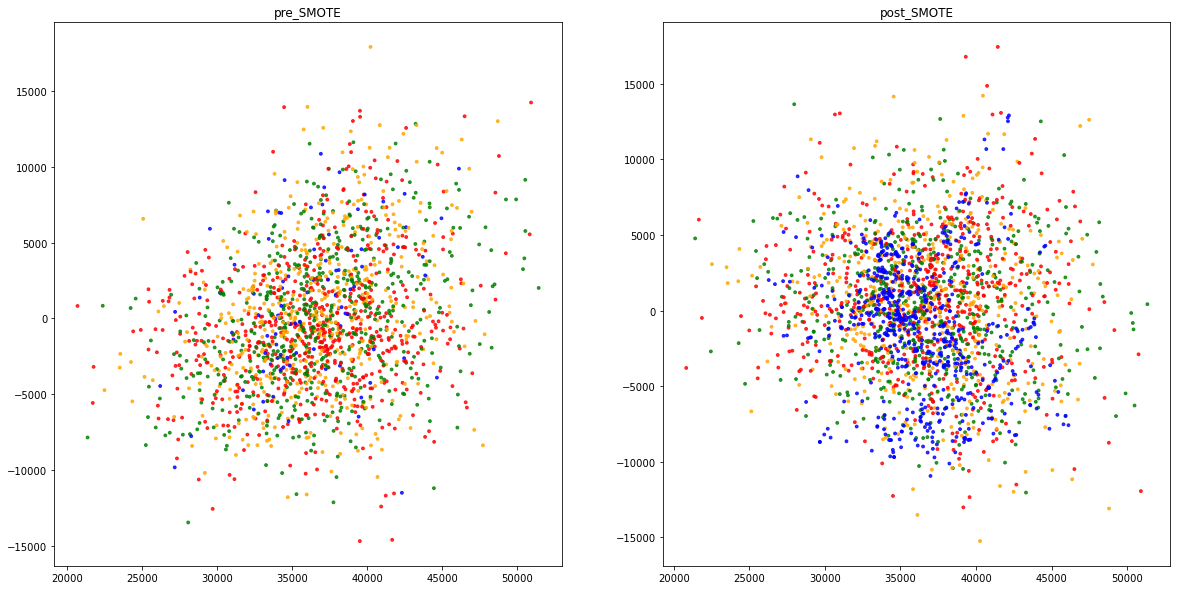

In [11]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
plot_LSA(x_train, y)
plt.title("pre_SMOTE")
fig.add_subplot(122)
plot_LSA(x_trainS, yS)
plt.title("post_SMOTE")

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_trainS)

U = pca.transform(x_trainS)
S = pca.explained_variance_
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

(2352, 2352)
(2352,)
(2352, 120000)


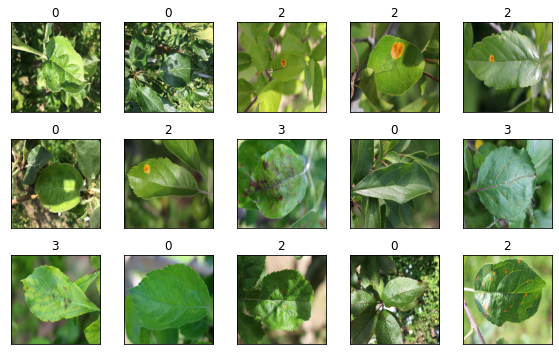

In [13]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(x_train[i].reshape(200,200,3)))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

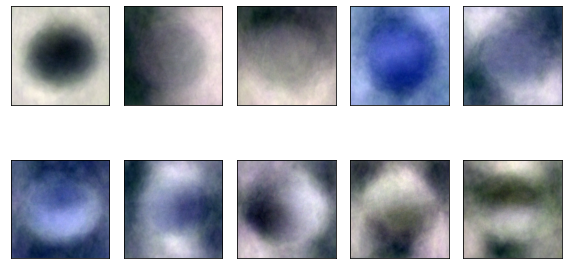

In [14]:
plt.figure(figsize=(8,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(V[i].reshape(200,200,3)))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

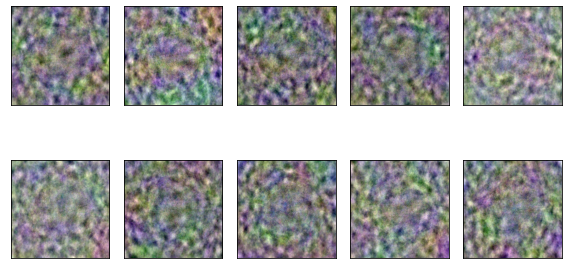

In [15]:
plt.figure(figsize=(8,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(V[200+i].reshape(200,200,3)))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

431


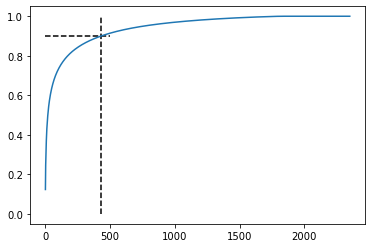

In [16]:
ev_cumsum = np.cumsum(pca.explained_variance_)/(pca.explained_variance_).sum()
ev_at90 = ev_cumsum[ev_cumsum<0.9].shape[0]
print (ev_at90)

plt.plot(ev_cumsum)
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.9, 0, 500, linestyles='dashed');

## Keras Implementation

Learning rate schedule: 1e-05 to 5e-05 to 1.18e-05


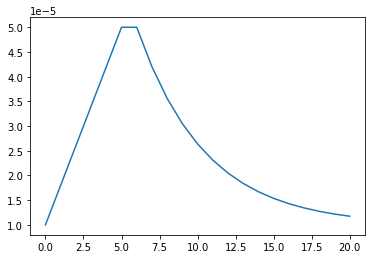

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=20)


def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=1, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn


lrfn =  build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
rng = [i for i in range(20+1)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [43]:
import tensorflow.keras.layers as L
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam , RMSprop

def get_deeper_model():
    reg = .0005
    
    METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.AUC(name='categorical_auc',multi_label=True),
        ]
    
    model = tf.keras.Sequential([DenseNet121(input_shape=(200, 200, 3),
                                weights='imagenet',
                                include_top=False),
                                L.GlobalAveragePooling2D(),
                                L.Dense(4,activation='softmax')])
        
    model.compile(optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=METRICS)
    
    print(model.summary())
    return model




# un'altra rete
def get_model(drop):
    
    METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.AUC(name='categorical_auc',multi_label=True),
        ]
    
    model = tf.keras.models.Sequential([
       # tf.keras.Input(shape=(150, 150, 3)),
        #data_augmentation(inputs),
    #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    #     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
        # The first convolution
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)), #, input_shape=(150, 150, 3)
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fifth convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a dense layer
        tf.keras.layers.Flatten(),
        # 128 neuron in the fully-connected layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(drop),
        # 5 output neurons for 5 classes with the softmax activation
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    #model.compile(loss='categorical_crossentropy', metrics = ['categorical_accuracy'],optimizer='adam')
    model.compile(RMSprop(lr=5e-4,momentum = 0.1),loss='categorical_crossentropy', metrics = METRICS)

    # Model Summary
    #print(model.summary())
    
    return model

SyntaxError: invalid syntax (<ipython-input-43-904da22135f3>, line 69)

## Train the models with validation

In [ ]:

drops =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
val_loss =[]
max_val_loss_epoch = []
val_acc = []
max_val_acc_epoch = []
val_auc = []
max_val_auc_epoch = []
histories = []
for drop in drops:
    i = 1
    model = get_model(drop)
    history = model.fit_generator(train_flow,
                steps_per_epoch = total_train // batch_size, #train_size//batch_size
                epochs=80, # the model never seems to suffer from validation loss increase (even up to 100 epochs)
                validation_data=val_flow,
                validation_steps=1, # we tried early stopping and learning rate scheduling, but they proved inefficient due to the high loss swipes we had during training.
                workers=4)   
    val_loss.append(np.max(np.array(history.history["val_loss"])))
    val_acc.append(np.max(np.array(history.history['val_categorical_accuracy'])))
    val_auc.append(np.max(np.array(history.history['val_categorical_auc'])))
    histories.append(history)
    print("drop  = ",drop, "done, next...")
    
history  = histories[np.argmax(np.array(val_auc))]
drop = drops[np.argmax(np.array(val_auc))]

fig, axs = plt.subplots(1,3, figsize = (15,15))
axs[0].set_title("val_loss")
axs[0].set_xlabel("dropout")
axs[0].set_ylabel("val_loss")
axs[0].plot(drops, val_loss)

axs[1].set_title("val_acc")
axs[1].set_xlabel("dropout")
axs[1].set_ylabel("val_acc")
axs[1].plot(drops, val_acc)

axs[2].set_title("val_auc")
axs[2].set_xlabel("dropout")
axs[2].set_ylabel("val_loss")
axs[2].plot(drops, val_auc) 

In [41]:
model = get_model(0.4)
history = model.fit_generator(train_flow,
            steps_per_epoch = total_train // batch_size, #train_size//batch_size
            epochs=80, # the model never seems to suffer from validation loss increase (even up to 100 epochs)
            validation_data=val_flow,
            validation_steps=1,        # we tried early stopping and learning rate scheduling, but they proved inefficient due to the high loss swipes we had during training.
            workers=4)   

Epoch 1/80
73/73 [==============================] - 4s 50ms/step - loss: 1.4291 - categorical_accuracy: 0.2621 - categorical_auc: 0.4822 - val_loss: 1.3702 - val_categorical_accuracy: 0.5000 - val_categorical_auc: 0.6216
Epoch 2/80
73/73 [==============================] - 3s 35ms/step - loss: 1.3131 - categorical_accuracy: 0.3884 - categorical_auc: 0.6532 - val_loss: 1.0631 - val_categorical_accuracy: 0.5714 - val_categorical_auc: 0.7551
Epoch 3/80
73/73 [==============================] - 3s 40ms/step - loss: 1.0993 - categorical_accuracy: 0.4940 - categorical_auc: 0.7615 - val_loss: 0.7972 - val_categorical_accuracy: 0.7033 - val_categorical_auc: 0.8157
Epoch 4/80
73/73 [==============================] - 3s 38ms/step - loss: 0.9790 - categorical_accuracy: 0.5715 - categorical_auc: 0.8176 - val_loss: 0.7728 - val_categorical_accuracy: 0.7115 - val_categorical_auc: 0.8287
Epoch 5/80
73/73 [==============================] - 3s 40ms/step - loss: 0.8751 - categorical_accuracy: 0.6082 - cat

In [20]:
deeper_model = get_deeper_model()
deeper_history = deeper_model.fit_generator(train_flow,
            steps_per_epoch = total_train // batch_size, #train_size//batch_size
            epochs=20, # the model never seems to suffer from validation loss increase (even up to 100 epochs)
            validation_data=val_flow,
            validation_steps=1,
            callbacks=[lr_schedule],        # we tried early stopping and learning rate scheduling, but they proved inefficient due to the high loss swipes we had during training.
            workers=4)

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 6, 6, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________
None

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
73/73 [==============================] - 18s 253ms/step - loss: 1.6005 - categorical_accuracy: 0.3418 - categorical_auc: 0.6515 - val_loss: 1.1639 - val_categorical_accuracy: 0.4863 - val_categorical_auc: 0.7235

Epoch 

## Plot training histories

In [42]:
def plot_train_history(history):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['categorical_accuracy'], marker=dict(color="dodgerblue"),
                name="Train acc"))

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['val_categorical_accuracy'], marker=dict(color="darkblue"),
                name="Val acc"))

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['categorical_auc'], marker=dict(color="orange"),
                name="Train auc"))

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['val_categorical_auc'], marker=dict(color="orangered"),
                name="Val auc"))



    fig.update_layout(title_text="", yaxis_title= "Metrics", xaxis_title="Epochs", template="plotly_white")

    fig.show()

plot_train_history(history)

In [22]:
plot_train_history(deeper_history)

## Plot Confusion Matrix

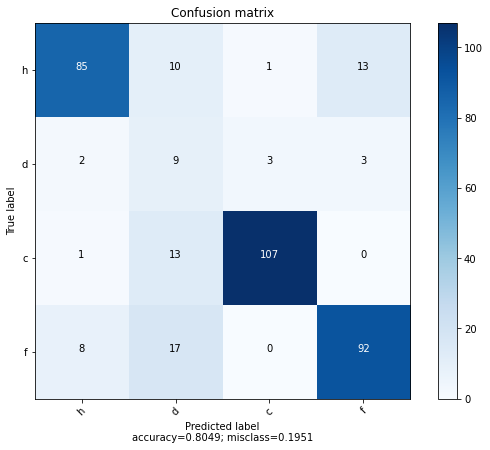

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

Y_pred = model.predict_generator(val_flow, train_size // batch_size +1) #128 +1
y_pred = np.argmax(Y_pred, axis=1)
a = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(a,["h","d","c","f"],normalize=True)

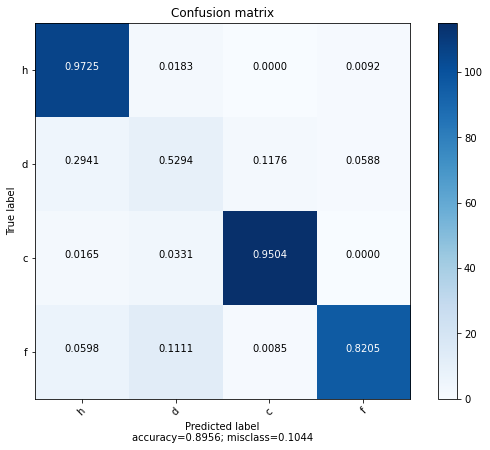

In [24]:
Y_pred = deeper_model.predict_generator(val_flow, train_size // batch_size +1) #128 +1
y_pred = np.argmax(Y_pred, axis=1)
a = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(a,["h","d","c","f"],normalize=True)

In [ ]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

## Train the models on all data and predict test

In [ ]:
del x,y,xS,yS

In [ ]:
test_imgs = get_augmented_test(test_dir = test_dir, test_generator = test_datagen)
print(test_imgs.shape)

In [ ]:
# To predict test

model1 = get_model(0.4)
model1.fit_generator(train_flow,
            steps_per_epoch = total_train // batch_size, #train_size//batch_size
            epochs=80,
            #callbacks=[ES_monitor,LR_reduce],
            workers=4)

def tensorSort(data):
    return sorted(data, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))

y_predicted = model1.predict(test_imgs)
submission = pd.DataFrame(y_predicted, columns = ["healthy", "multiple_diseases", "rust","scab"],)
submission.insert(0,"image_id",tensorSort(test_csv["image_id"].tolist()))
submission.to_csv("../working/submission.csv", index = False)
submission

In [ ]:
# To predict test

#model1 = get_model()
deeper_model1 = get_deeper_model()

#train_flow,total_train = create_augmented_data(train_dst_dir  = train_dst_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = 32, valid = False )
deeper_model1.fit_generator(train_flow,
            steps_per_epoch = total_train // batch_size, #train_size//batch_size
            epochs=20,
            callbacks=[lr_schedule],
            workers=4)

def tensorSort(data):
    return sorted(data, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))

y_predicted = deeper_model1.predict(test_imgs)
submission = pd.DataFrame(y_predicted, columns = ["healthy", "multiple_diseases", "rust","scab"],)
submission.insert(0,"image_id",tensorSort(test_csv["image_id"].tolist()))
submission.to_csv("../working/deeper_submission.csv", index = False)
submission

# Filters and Feature Maps 

## Modules 

In [ ]:
import time
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import glob
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as pil_image
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as L

# Import module we'll need to import our custom module
from shutil import copyfile

# Copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/filter-visualization-modules/conv_filter_visualization.py", dst = "../working/conv_filter_visualization.py")
copyfile(src = "../input/othermodules/model.py", dst = "../working/model.py")
copyfile(src = "../input/othermodules/viz.py", dst = "../working/viz.py")
copyfile(src = "../input/othermodules/utils.py", dst = "../working/utils.py")

# Import all functions
from conv_filter_visualization import *

# Models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Filter Visualization (VGG16 Keras Model)

In [ ]:
import time
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import glob
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as pil_image
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as L

# Import module we'll need to import our custom module
from shutil import copyfile

# Copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/filter-visualization-modules/conv_filter_visualization.py", dst = "../working/conv_filter_visualization.py")
copyfile(src = "../input/othermodules/model.py", dst = "../working/model.py")
copyfile(src = "../input/othermodules/viz.py", dst = "../working/viz.py")
copyfile(src = "../input/othermodules/utils.py", dst = "../working/utils.py")

# Import all functions
from conv_filter_visualization import *

# Models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Filter Visualization (InPhyT Model) 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import glob
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the model
model = tf.keras.models.Sequential([
   # tf.keras.Input(shape=(150, 150, 3)),
    #data_augmentation(inputs),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)), #, input_shape=(150, 150, 3)
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', metrics = ['categorical_accuracy'],optimizer='adam')

# Model Summary
model.summary()

# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# layer_name = '' 
input_image = "../input/plantvillage/plantvillage_split_dataset/test_images/Test_100.jpg" 

# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 7, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray') 
        ix += 1
# show the figure
pyplot.show()

## Feature Map Visualization (InPhyT Model)

In [ ]:
# Model building

model = tf.keras.models.Sequential([
    # tf.keras.Input(shape=(150, 150, 3)),
    # data_augmentation(inputs),
    # tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    # tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)), # input_shape=(150, 150, 3)
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(4, activation='softmax')
])

# redefine model to output right after the first hidden layer
ixs = [2,3,4,5,6,7,8, 9, 10]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img(input_image, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 5

#fig, ax = subplots(figsize=(18, 2))
#ax.imshow(random.rand(8, 90), interpolation='nearest'

for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    plt.figure(figsize = (15,15))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            try:
                pyplot.imshow(fmap[0, :, :, ix-1], cmap = 'gray')
            except:
                print("", end = "\r")
            ix += 1
    # show the figure
    pyplot.show()

## Filter Visualization (DenseNet121 Keras Model) 

In [ ]:
# # Load the model 
# model = tf.keras.Sequential([DenseNet121(input_shape=(224, 224, 3),
#                                          weights='imagenet',
#                                          include_top=False),
#                              L.GlobalAveragePooling2D(),
#                              L.Dense(4,activation='softmax')])
        
# model.compile(loss='categorical_crossentropy', metrics = ['categorical_accuracy'], optimizer='adam')

# # Model Summary
# model.summary()

# # redefine model to output right after the first hidden layer
# model = Model(inputs=model.inputs, outputs=model.layers[1].output)

# # get the symbolic outputs of each "key" layer (we gave them unique names).
# layer_dict = dict([(layer.name, layer) for layer in model.layers])

# # layer_name = '' 
# input_image = "../input/plantvillage/plantvillage_split_dataset/test_images/Test_100.jpg" 

# # retrieve weights from the second hidden layer
# filters, biases = model.layers[1].get_weights()

# # normalize filter values to 0-1 so we can visualize them
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)

# # plot first few filters
# n_filters, ix = 7, 1
# for i in range(n_filters):
#     # get the filter
#     f = filters[:, :, :, i]
#     # plot each channel separately
#     for j in range(3):
#         # specify subplot and turn of axis
#         ax = pyplot.subplot(n_filters, 3, ix)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         # plot filter channel in grayscale
#         pyplot.imshow(f[:, :, j], cmap='gray') 
#         ix += 1
# # show the figure
# pyplot.show()

## Feature Map Visualization (DenseNet121 Keras Model)

In [ ]:
# # Load the model 
# model = tf.keras.Sequential([DenseNet121(input_shape=(224, 224, 3),
#                                          weights='imagenet',
#                                          include_top=False),
#                              L.GlobalAveragePooling2D(),
#                              L.Dense(4,activation='softmax')])

# # redefine model to output right after the first hidden layer
# ixs = [1,2]
# outputs = [model.layers[i].output for i in ixs]
# model = Model(inputs=model.inputs, outputs=outputs)
# # load the image with the required shape
# img = load_img(input_image, target_size=(224, 224))
# # convert the image to an array
# img = img_to_array(img)
# # expand dimensions so that it represents a single 'sample'
# img = expand_dims(img, axis=0)
# # prepare the image (e.g. scale pixel values for the vgg)
# img = preprocess_input(img)
# # get feature map for first hidden layer
# feature_maps = model.predict(img)
# # plot the output from each block
# square = 5

# #fig, ax = subplots(figsize=(18, 2))
# #ax.imshow(random.rand(8, 90), interpolation='nearest'

# for fmap in feature_maps:
#     # plot all 64 maps in an 8x8 squares
#     ix = 1
#     plt.figure(figsize = (15,15))
#     for _ in range(square):
#         for _ in range(square):
#             # specify subplot and turn of axis
#             ax = pyplot.subplot(square, square, ix)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             # plot filter channel in grayscale
#             pyplot.imshow(fmap[0, :, :, ix-1], cmap = 'gray')
#             ix += 1
#     # show the figure
#     pyplot.show()

In [ ]:
# model.summary()